In [94]:
import torch

import cv2

import torch.nn.functional as F

import torchvision

import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

from torchvision import models

from PIL import Image


Step 1: Load Pretrained ResNet18 (fine-tuned or standard)

In [95]:
# Load pretrained ResNet18 (fine-tuned one if available)

model = models.resnet18(pretrained = True)

model.eval()

/opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Step 2: Choose Layer for Grad-CAM (usually last conv layer)


In [96]:
# Target the final convolutional layer in ResNet18

target_layer = model.layer4[-1]

Step 3: Load and Preprocess Image

In [97]:
# Load sample image from local

img = Image.open("Husky Love.jpg").convert("RGB")  # Convert to grayscale


In [98]:
# Preprocess to match model expectations

transform = transforms.Compose([

    transforms.Resize((224,224)),

    transforms.ToTensor(),

    transforms.Normalize(

                mean=[0.485, 0.456, 0.406],  # ImageNet stats

                std=[0.229, 0.224, 0.225]

    )
])

input_tensor = transform(img).unsqueeze(0)  # Shape: [1, 3, 224, 224]

⚙️ Step 4: Grad-CAM Hook Setup

We'll register hooks to capture the features and gradients:

In [99]:
# Placeholders to save features and gradients

features = []

gradients = []

# Hook to capture forward feature maps

def forward_hook(module, input, output):

    features.append(output)


# Hook to capture gradients from backward pass

def backward_hook(module, grade_in, grade_out):

    gradients.append(grade_out[0])


# Register hooks

handle_fwd = target_layer.register_forward_hook(forward_hook)

handle_bwd =   target_layer.register_backward_hook(backward_hook)

Step 5: Forward + Backward Pass

In [100]:
# Forward pass

output = model(input_tensor)


# Predicted class (highest logit)

pred_class = output.argmax(dim=1).item()


# Backward pass: compute gradients w.r.t predicted class

model.zero_grad()

output[0, pred_class].backward()

/opt/anaconda3/envs/masterxdl/lib/python3.9/site-packages/torch/nn/modules/module.py:1831: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Step 6: Generate Grad-CAM Heatmap

In [101]:
# Get feature maps and gradients

gradients = gradients[0]

features = features[0]


# Global average pooling on gradients → channel-wise importance

weights = gradients.mean(dim=(2,3) , keepdim = True) # Shape: [1, C, 1, 1]



# Weighted sum of features

cam = (weights * features).sum(dim=1, keepdim = True) # Shape: [1, 1, H, W]

cam = F.relu(cam)


# Normalize

cam = cam.squeeze().detach().cpu().numpy()

cam = (cam - cam.min()) / (cam.max() - cam.min())

Step 7: Overlay Heatmap on Original Image

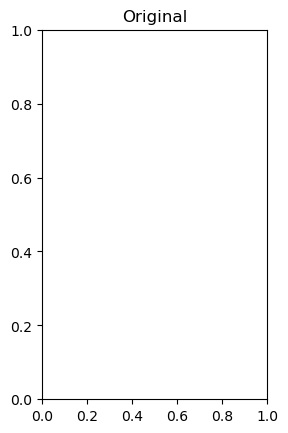

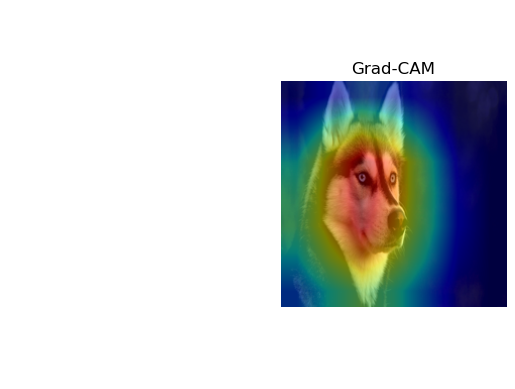

In [102]:
def show_cam_on_image(img, cam):


    img_resized = img.resize((224, 224))  # Resize image first

    img_np = np.array(img_resized) / 255.0  # Normalize to [0, 1]


    # Resize CAM to match image size
    cam_resized = cv2.resize(cam, (224, 224))

    # Create heatmap from CAM
    heatmap = plt.cm.jet(cam_resized)[..., :3] # RGB Only



    overlay = 0.5 * img_np + 0.5 * heatmap

    overlay = np.clip(overlay, 0, 1)
    

    # Plot both original and Grad-CAM images
    plt.figure.figsize=(8,4)

    plt.subplot(1, 2, 1)

    plt.title('Original')

    plt.show(img)

    plt.axis('off')


    plt.subplot(1, 2, 2)

    plt.title('Grad-CAM')

    plt.imshow(overlay)

    plt.axis('off')

    plt.show()


# Show final Grad-CAM overlay
show_cam_on_image(img, cam)